# Thư viện và dữ liệu

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/hello_tlu')
import Fx
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import optuna
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/hello_tlu/Tokyo_eurusd.csv')
df

,Position_MACD,Position_AO,Position_RSI,trend_1h,trend_4h,trend_8h,trend_day,trend_week,trend_month,Datetime,Close,label
0,0,0,1,0.000259,0.002720,0.001622,-0.003664,-0.018713,-0.030232,2010-02-01 06:00:00,1.38961,0.0
1,0,0,1,0.000079,0.001629,0.000483,-0.003929,-0.017949,-0.030146,2010-02-01 06:15:00,1.38920,0.0
2,0,0,1,-0.000778,0.000029,-0.000396,-0.005069,-0.018497,-0.031539,2010-02-01 06:30:00,1.38763,0.0
3,0,0,1,0.000908,0.001045,0.001709,-0.004863,-0.018049,-0.029374,2010-02-01 06:45:00,1.38948,0.0
4,0,0,1,-0.000201,0.001175,0.001110,-0.004471,-0.016779,-0.027754,2010-02-01 07:00:00,1.38933,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
147817,-1,0,-1,0.000251,0.000623,0.000483,0.003055,0.005199,-0.006018,2024-05-06 01:45:00,1.07690,0.0
147818,-1,0,-1,0.000139,0.000511,0.000307,0.002971,0.005012,-0.006386,2024-05-06 02:00:00,1.07677,0.0
147819,-1,0,-1,0.000399,0.000604,0.000390,0.003364,0.004993,-0.006257,2024-05-06 02:15:00,1.07687,0.0
147820,-1,0,-1,0.000195,0.000493,0.000111,0.003168,0.004563,-0.006771,2024-05-06 02:30:00,1.07665,0.0


In [4]:
train = df[df['Datetime'].between('2010-01-01', '2017-12-31')]
valdian = df[df['Datetime'].between('2017-01-01', '2020-12-31')]
test1 = df[df['Datetime'].between('2020-01-01', '2023-12-31')]
test2 = df[df['Datetime'].between('2023-01-01', '2024-12-31')]

features = df.columns[:-3]
target = 'label'

# Decision Tree

In [11]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 50,2),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20,2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10,2)
    }

    # Tạo và huấn luyện mô hình Decision Tree với các tham số được đề xuất
    dt_model = DecisionTreeClassifier(**params)
    dt_model.fit(train[features], train[target])

    # Đánh giá hiệu suất của mô hình trên tập train và tập validation
    train_pred = dt_model.predict(train[features])
    val_pred = dt_model.predict(valdian[features])

    train_accuracy = accuracy_score(train[target], train_pred)
    val_accuracy = accuracy_score(valdian[target], val_pred)

    # Trả về giá trị ngược của accuracy trên tập validation
    # cộng với sự chênh lệch giữa accuracy trên tập train và tập validation
    return 1-val_accuracy, np.abs(train_accuracy-val_accuracy)

# Tạo một study object và optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)




[I 2024-05-24 17:30:23,475] A new study created in memory with name: no-name-12992697-00e6-4a82-af4c-ad660999cccc
[W 2024-05-24 17:30:25,706] Trial 0 failed with parameters: {'max_depth': 47, 'min_samples_split': 18, 'min_samples_leaf': 1} because of the following error: The number of the values 2 did not match the number of the objectives 1.
[W 2024-05-24 17:30:25,712] Trial 0 failed with value (0.4207448222528336, 0.2158897197643499).
[W 2024-05-24 17:30:26,411] Trial 1 failed with parameters: {'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 9} because of the following error: The number of the values 2 did not match the number of the objectives 1.
[W 2024-05-24 17:30:26,416] Trial 1 failed with value (0.36661108291645517, 0.008148233664499793).
[W 2024-05-24 17:30:28,939] Trial 2 failed with parameters: {'max_depth': 37, 'min_samples_split': 10, 'min_samples_leaf': 1} because of the following error: The number of the values 2 did not match the number of the objectives 1.

In [12]:
best_params = {'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 9}
print("Best parameters:", best_params)

best_dt_model = DecisionTreeClassifier(**best_params)
best_dt_model.fit(train[features], train[target])

test1_pred_best_dt = best_dt_model.predict(test1[features])
acc_best_dt = accuracy_score(test1[target], test1_pred_best_dt)
f1_best_dt = f1_score(test1[target], test1_pred_best_dt, average='macro')
# precision_best_dt, recall_best_dt, _ = precision_recall_curve(test1[target], test1_pred_best_dt)

print("Best Decision Tree:")
print("Accuracy:", acc_best_dt)
print("F1-score:", f1_best_dt)




Best parameters: {'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 9}
Best Decision Tree:
Accuracy: 0.6264575503517394
F1-score: 0.276557335935054


Margin: -0.46222375897547086
MDD: 0.0826199679904243

   Total trading quantity: 679
 Trading quantity per day: 0.6528846153846154
          Return per year: -0.015244471502029226
                  HitRate: 0.4521354933726068
          HitRate per day: 0.18864292589027912


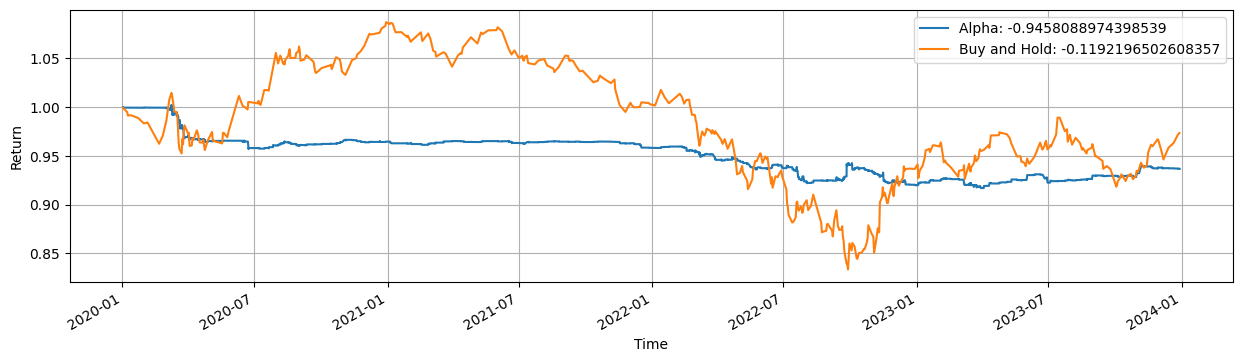

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2020-01-01 03:00:00,0,0.0,0.0,NaN,NaN,NaN
2020-01-02 03:00:00,0.0,0.0,0.0,0.0,1.12142,NaN
2020-01-02 03:15:00,0.0,0.0,0.0,0.0,1.12122,1.000000
2020-01-02 03:30:00,0.0,0.0,0.0,0.0,1.12096,1.000000
2020-01-02 03:45:00,0.0,0.0,0.0,0.0,1.12011,1.000000
...,...,...,...,...,...,...
2023-12-29 08:45:00,-0.06869,0.0,-0.06869,0.0,1.10594,0.936717
2023-12-29 09:00:00,-0.06869,0.0,-0.06869,0.0,1.10545,0.936717
2023-12-29 09:15:00,-0.06869,0.0,-0.06869,0.0,1.10507,0.936717


In [13]:
backTestInfo = Fx.BacktestInformation(test1['Datetime'], test1_pred_best_dt,test1['Close'],fee=0)
backTestInfo.Plot_PNL()

Best Decision Tree:
Accuracy: 0.6264012647312446
F1-score: 0.2678187324191739
Margin: 0.4732876755357239
MDD: 0.010100167992046414

   Total trading quantity: 174
 Trading quantity per day: 0.49714285714285716
          Return per year: 0.0112530831793592
                  HitRate: 0.5172413793103449
          HitRate per day: 0.20916905444126074


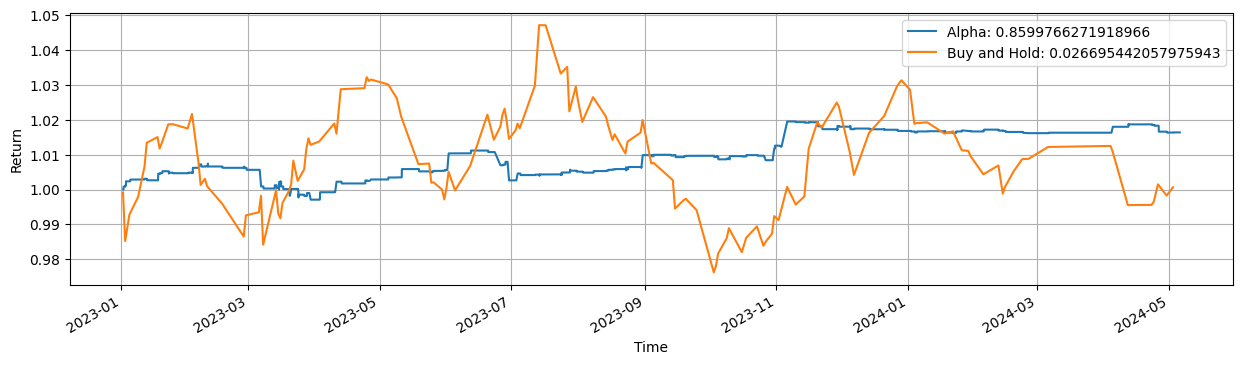

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2023-01-01 04:00:00,0,0.0,0.0,NaN,NaN,NaN
2023-01-02 04:00:00,0.0,0.0,0.0,0.0,1.06972,NaN
2023-01-02 04:15:00,0.0,0.0,0.0,0.0,1.06938,1.000000
2023-01-02 04:30:00,0.0,0.0,0.0,0.0,1.06951,1.000000
2023-01-02 04:45:00,0.0,0.0,0.0,0.0,1.06967,1.000000
...,...,...,...,...,...,...
2024-05-06 01:45:00,0.01778,0.0,0.01778,0.0,1.07690,1.016392
2024-05-06 02:00:00,0.01778,0.0,0.01778,0.0,1.07677,1.016392
2024-05-06 02:15:00,0.01778,0.0,0.01778,0.0,1.07687,1.016392


In [14]:
test2_pred_best_dt = best_dt_model.predict(test2[features])
acc_best_dt = accuracy_score(test2[target], test2_pred_best_dt)
f1_best_dt = f1_score(test2[target], test2_pred_best_dt, average='macro')
# precision_best_dt, recall_best_dt, _ = precision_recall_curve(test2[target], test2_pred_best_dt)

print("Best Decision Tree:")
print("Accuracy:", acc_best_dt)
print("F1-score:", f1_best_dt)

backTestInfo = Fx.BacktestInformation(test2['Datetime'], test2_pred_best_dt,test2['Close'],fee=0)
backTestInfo.Plot_PNL()

# GaussianNB

In [23]:


best_nb_model = GaussianNB()
best_nb_model.fit(train[features], train[target])

test1_pred_best_nb = best_nb_model.predict(test1[features])
acc_best_nb = accuracy_score(test1[target], test1_pred_best_nb)
f1_best_nb = f1_score(test1[target], test1_pred_best_nb, average='macro')
# precision_best_nb, recall_best_nb, _ = precision_recall_curve(test1[target], test1_pred_best_nb)

print("Best Decision Tree:")
print("Accuracy:", acc_best_nb)
print("F1-score:", f1_best_nb)




Best Decision Tree:
Accuracy: 0.6154476245543028
F1-score: 0.3267789467089423


Margin: -0.15769622823420887
MDD: 0.11617161838256812

   Total trading quantity: 1121
 Trading quantity per day: 1.078922040423484
          Return per year: -0.00826132150448731
                  HitRate: 0.33987511150758254
          HitRate per day: 0.24277456647398843


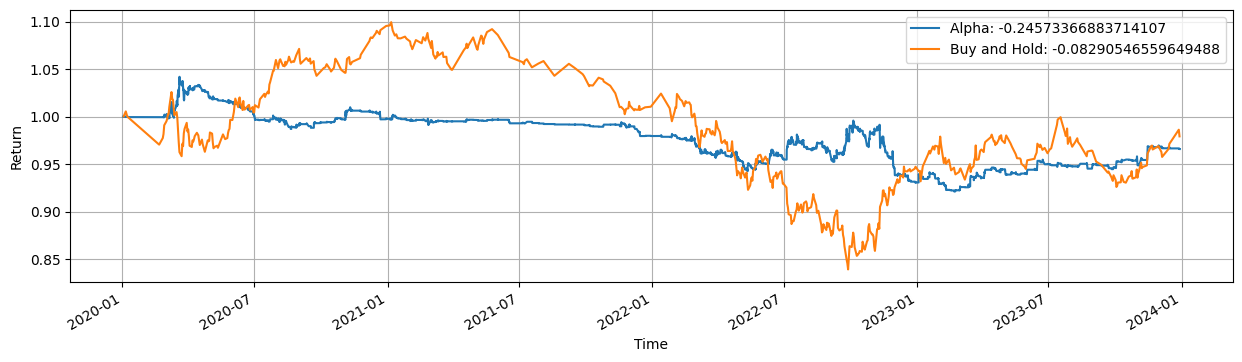

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2020-01-02 03:00:00,0.00000,0.0,0.00000,0.0,1.12142,NaN
2020-01-02 03:15:00,0.00000,0.0,0.00000,0.0,1.12122,1.000000
2020-01-02 03:30:00,0.00000,0.0,0.00000,0.0,1.12096,1.000000
2020-01-02 03:45:00,0.00000,0.0,0.00000,0.0,1.12011,1.000000
2020-01-02 04:00:00,0.00000,0.0,0.00000,0.0,1.12011,1.000000
...,...,...,...,...,...,...
2023-12-29 08:45:00,-0.03854,0.0,-0.03854,0.0,1.10594,0.965989
2023-12-29 09:00:00,-0.03854,0.0,-0.03854,0.0,1.10545,0.965989
2023-12-29 09:15:00,-0.03854,0.0,-0.03854,-1.0,1.10507,0.965989


In [18]:
backTestInfo = Fx.BacktestInformation(test1['Datetime'], test1_pred_best_nb,test1['Close'],fee=0)
backTestInfo.Plot_PNL()

Best Decision Tree:
Accuracy: 0.6193590112101178
F1-score: 0.2952115990789527
Margin: 0.646316279079359
MDD: 0.018741341163043122

   Total trading quantity: 233
 Trading quantity per day: 0.667621776504298
          Return per year: 0.02198607646702768
                  HitRate: 0.36909871244635195
          HitRate per day: 0.21551724137931033


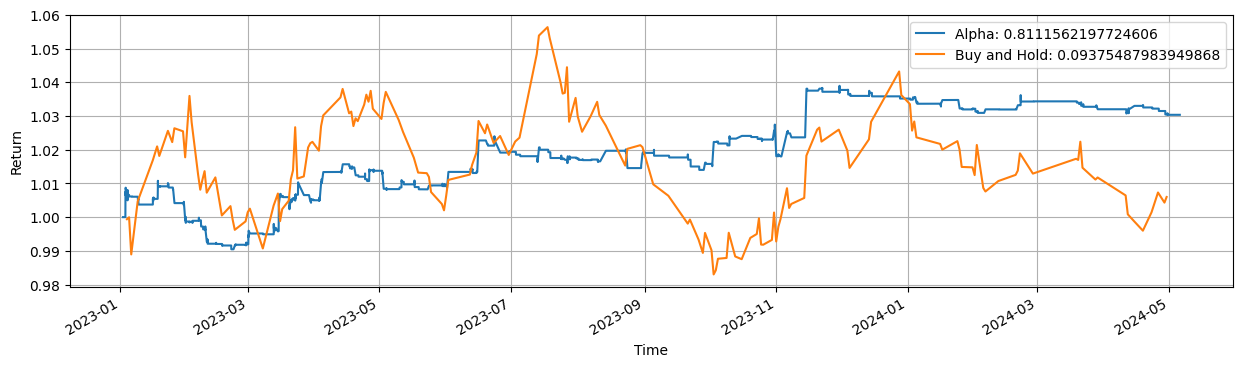

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2023-01-02 04:00:00,0.00000,0.0,0.00000,0.0,1.06972,NaN
2023-01-02 04:15:00,0.00000,0.0,0.00000,0.0,1.06938,1.000000
2023-01-02 04:30:00,0.00000,0.0,0.00000,0.0,1.06951,1.000000
2023-01-02 04:45:00,0.00000,0.0,0.00000,0.0,1.06967,1.000000
2023-01-02 05:00:00,0.00000,0.0,0.00000,0.0,1.06952,1.000000
...,...,...,...,...,...,...
2024-05-06 01:45:00,0.03256,0.0,0.03256,0.0,1.07690,1.030362
2024-05-06 02:00:00,0.03256,0.0,0.03256,0.0,1.07677,1.030362
2024-05-06 02:15:00,0.03256,0.0,0.03256,0.0,1.07687,1.030362


In [19]:
test2_pred_best_nb = best_nb_model.predict(test2[features])
acc_best_nb = accuracy_score(test2[target], test2_pred_best_nb)
f1_best_nb = f1_score(test2[target], test2_pred_best_nb, average='macro')
# precision_best_nb, recall_best_nb, _ = precision_recall_curve(test2[target], test2_pred_best_nb)

print("Best Decision Tree:")
print("Accuracy:", acc_best_nb)
print("F1-score:", f1_best_nb)

backTestInfo = Fx.BacktestInformation(test2['Datetime'], test2_pred_best_nb,test2['Close'],fee=0)
backTestInfo.Plot_PNL()

# Random forest

In [5]:

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }

    # Tạo và huấn luyện mô hình Random Forest với các tham số được đề xuất
    rf_model = RandomForestClassifier(**params)
    rf_model.fit(train[features], train[target])

    # Đánh giá hiệu suất của mô hình trên tập train và tập validation
    train_pred = rf_model.predict(train[features])
    val_pred = rf_model.predict(valdian[features])

    train_accuracy = accuracy_score(train[target], train_pred)
    val_accuracy = accuracy_score(valdian[target], val_pred)

    # Trả về giá trị ngược của accuracy trên tập validation
    # cộng với sự chênh lệch giữa accuracy trên tập train và tập validation
    return 1 - val_accuracy+ np.abs(train_accuracy - val_accuracy)

# Tạo một study object và optimize cho Random Forest
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=50)


[I 2024-05-24 17:40:55,808] A new study created in memory with name: no-name-6e2da7c3-5c6b-4dc2-9268-ac51dce3a2b2
[I 2024-05-24 17:41:18,826] Trial 0 finished with value: 0.3783738981111733 and parameters: {'n_estimators': 38, 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.3783738981111733.
[I 2024-05-24 17:41:26,555] Trial 1 finished with value: 0.3712739769431378 and parameters: {'n_estimators': 24, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.3712739769431378.
[I 2024-05-24 17:41:49,518] Trial 2 finished with value: 0.38530421399740344 and parameters: {'n_estimators': 78, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.3712739769431378.
[I 2024-05-24 17:41:56,877] Trial 3 finished with value: 0.4007386468748422 and parameters: {'n_estimators': 21, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 3}. Best is trial 1 with value:

In [7]:
best_params = study_rf.best_params
print("Best parameters:", best_params)

best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(train[features], train[target])

test1_pred_best_rf = best_rf_model.predict(test1[features])
acc_best_rf = accuracy_score(test1[target], test1_pred_best_rf)
f1_best_rf = f1_score(test1[target], test1_pred_best_rf, average='macro')
# precision_best_rf, recall_best_rf, _ = precision_recall_curve(test1[target], test1_pred_best_rf)

print("Best Decision Tree:")
print("Accuracy:", acc_best_rf)
print("F1-score:", f1_best_rf)




Best parameters: {'n_estimators': 53, 'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 10}
Best Decision Tree:
Accuracy: 0.6332273296713886
F1-score: 0.2616622929459445


Margin: -1.7932593895223006
MDD: 0.037584063206925505

   Total trading quantity: 70
 Trading quantity per day: 0.06737247353224254
          Return per year: -0.0060510643855304835
                  HitRate: 0.38571428571428573
          HitRate per day: 0.022157996146435453


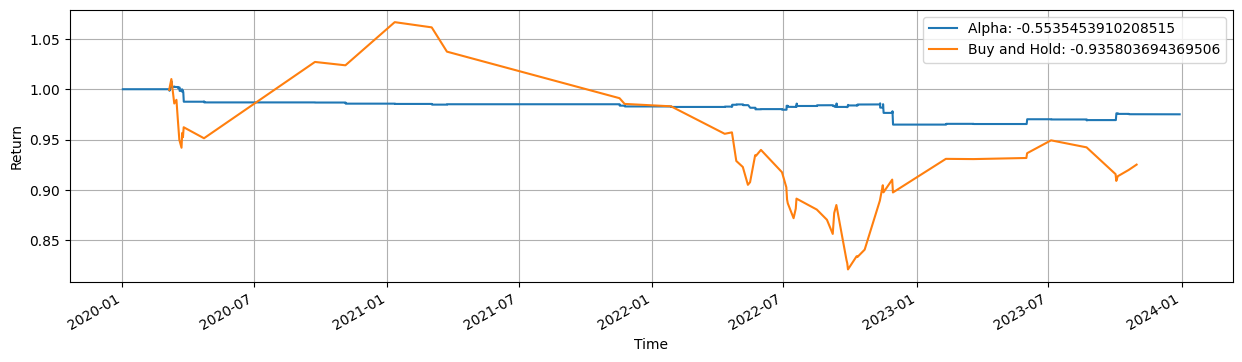

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2020-01-02 03:00:00,0.00000,0.0,0.00000,0.0,1.12142,NaN
2020-01-02 03:15:00,0.00000,0.0,0.00000,0.0,1.12122,1.000000
2020-01-02 03:30:00,0.00000,0.0,0.00000,0.0,1.12096,1.000000
2020-01-02 03:45:00,0.00000,0.0,0.00000,0.0,1.12011,1.000000
2020-01-02 04:00:00,0.00000,0.0,0.00000,0.0,1.12011,1.000000
...,...,...,...,...,...,...
2023-12-29 08:45:00,-0.02666,0.0,-0.02666,0.0,1.10594,0.975075
2023-12-29 09:00:00,-0.02666,0.0,-0.02666,0.0,1.10545,0.975075
2023-12-29 09:15:00,-0.02666,0.0,-0.02666,0.0,1.10507,0.975075


In [8]:
backTestInfo = Fx.BacktestInformation(test1['Datetime'], test1_pred_best_rf,test1['Close'],fee=0)
backTestInfo.Plot_PNL()

Best Decision Tree:
Accuracy: 0.632868640413912
F1-score: 0.2589069551612551
Margin: 4.599585272144984
MDD: 0.0009949723558510728

   Total trading quantity: 11
 Trading quantity per day: 0.03151862464183381
          Return per year: 0.007404192925053673
                  HitRate: 0.36363636363636365
          HitRate per day: 0.011494252873563218


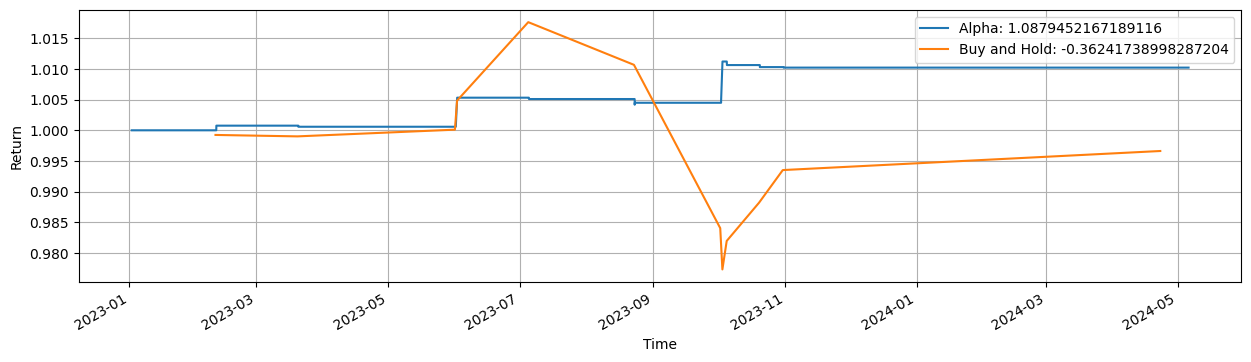

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2023-01-02 04:00:00,0.00000,0.0,0.00000,0.0,1.06972,NaN
2023-01-02 04:15:00,0.00000,0.0,0.00000,0.0,1.06938,1.000000
2023-01-02 04:30:00,0.00000,0.0,0.00000,0.0,1.06951,1.000000
2023-01-02 04:45:00,0.00000,0.0,0.00000,0.0,1.06967,1.000000
2023-01-02 05:00:00,0.00000,0.0,0.00000,0.0,1.06952,1.000000
...,...,...,...,...,...,...
2024-05-06 01:45:00,0.01082,0.0,0.01082,0.0,1.07690,1.010225
2024-05-06 02:00:00,0.01082,0.0,0.01082,0.0,1.07677,1.010225
2024-05-06 02:15:00,0.01082,0.0,0.01082,0.0,1.07687,1.010225


In [9]:
test2_pred_best_rf = best_rf_model.predict(test2[features])
acc_best_rf = accuracy_score(test2[target], test2_pred_best_rf)
f1_best_rf = f1_score(test2[target], test2_pred_best_rf, average='macro')
# precision_best_rf, recall_best_rf, _ = precision_recall_curve(test2[target], test2_pred_best_rf)

print("Best Decision Tree:")
print("Accuracy:", acc_best_rf)
print("F1-score:", f1_best_rf)

backTestInfo = Fx.BacktestInformation(test2['Datetime'], test2_pred_best_rf,test2['Close'],fee=0)
backTestInfo.Plot_PNL()

# Gradient boosting tree

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }

    gb_model = GradientBoostingClassifier(**params)
    gb_model.fit(train[features], train[target])

    train_pred = gb_model.predict(train[features])
    val_pred = gb_model.predict(valdian[features])

    train_accuracy = accuracy_score(train[target], train_pred)
    val_accuracy = accuracy_score(valdian[target], val_pred)
    return 1 - val_accuracy+ np.abs(train_accuracy - val_accuracy)

study_gb = optuna.create_study(direction='minimize')
study_gb.optimize(objective_gb, n_trials=10)


[I 2024-05-24 18:40:52,870] A new study created in memory with name: no-name-ceb544ae-f76f-4aa3-85f4-ec1bc519abcc
[I 2024-05-24 18:41:35,352] Trial 0 finished with value: 0.36908040654171437 and parameters: {'n_estimators': 14, 'learning_rate': 0.060230582003653686, 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.36908040654171437.
[I 2024-05-24 18:41:55,553] Trial 1 finished with value: 0.37446684052743184 and parameters: {'n_estimators': 11, 'learning_rate': 0.06064921480608457, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.36908040654171437.
[I 2024-05-24 18:43:13,146] Trial 2 finished with value: 0.3904207593238931 and parameters: {'n_estimators': 29, 'learning_rate': 0.08859372622371553, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.36908040654171437.
[I 2024-05-24 18:50:58,952] Trial 3 finished with value: 0.5536038972907115 and paramete

In [12]:
best_params = study_gb.best_params
print("Best parameters:", best_params)

best_gb_model = GradientBoostingClassifier(**best_params)
best_gb_model.fit(train[features], train[target])

test1_pred_best_gb = best_gb_model.predict(test1[features])
acc_best_gb = accuracy_score(test1[target], test1_pred_best_gb)
f1_best_gb = f1_score(test1[target], test1_pred_best_gb, average='macro')
# precision_best_gb, recall_best_gb, _ = precision_recall_curve(test1[target], test1_pred_best_gb)

print("Best Decision Tree:")
print("Accuracy:", acc_best_gb)
print("F1-score:", f1_best_gb)




Best parameters: {'n_estimators': 14, 'learning_rate': 0.060230582003653686, 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 8}
Best Decision Tree:
Accuracy: 0.6338296232051652
F1-score: 0.26044668920054864


Margin: 0.7070625782943981
MDD: 0.00981566076233899

   Total trading quantity: 40
 Trading quantity per day: 0.03849855630413859
          Return per year: 0.0014014187165929714
                  HitRate: 0.525
          HitRate per day: 0.02023121387283237


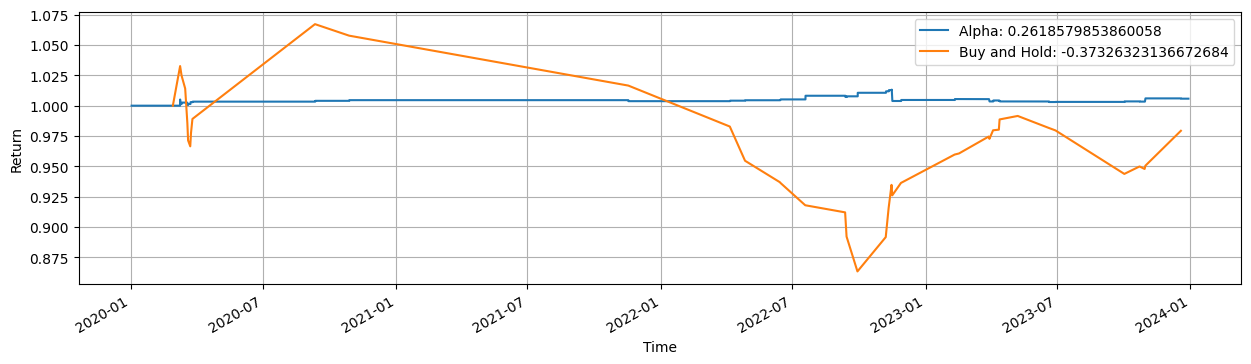

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2020-01-02 03:00:00,0.00000,0.0,0.00000,0.0,1.12142,NaN
2020-01-02 03:15:00,0.00000,0.0,0.00000,0.0,1.12122,1.000000
2020-01-02 03:30:00,0.00000,0.0,0.00000,0.0,1.12096,1.000000
2020-01-02 03:45:00,0.00000,0.0,0.00000,0.0,1.12011,1.000000
2020-01-02 04:00:00,0.00000,0.0,0.00000,0.0,1.12011,1.000000
...,...,...,...,...,...,...
2023-12-29 08:45:00,0.00608,0.0,0.00608,0.0,1.10594,1.005773
2023-12-29 09:00:00,0.00608,0.0,0.00608,0.0,1.10545,1.005773
2023-12-29 09:15:00,0.00608,0.0,0.00608,0.0,1.10507,1.005773


In [13]:
backTestInfo = Fx.BacktestInformation(test1['Datetime'], test1_pred_best_gb,test1['Close'],fee=0)
backTestInfo.Plot_PNL()

Best Decision Tree:
Accuracy: 0.6335872377119862
F1-score: 0.26038370901139757
Margin: 0.3802890836775043
MDD: 0.002445283385256302

   Total trading quantity: 13
 Trading quantity per day: 0.03724928366762178
          Return per year: 0.0007754589567360638
                  HitRate: 0.38461538461538464
          HitRate per day: 0.014367816091954023


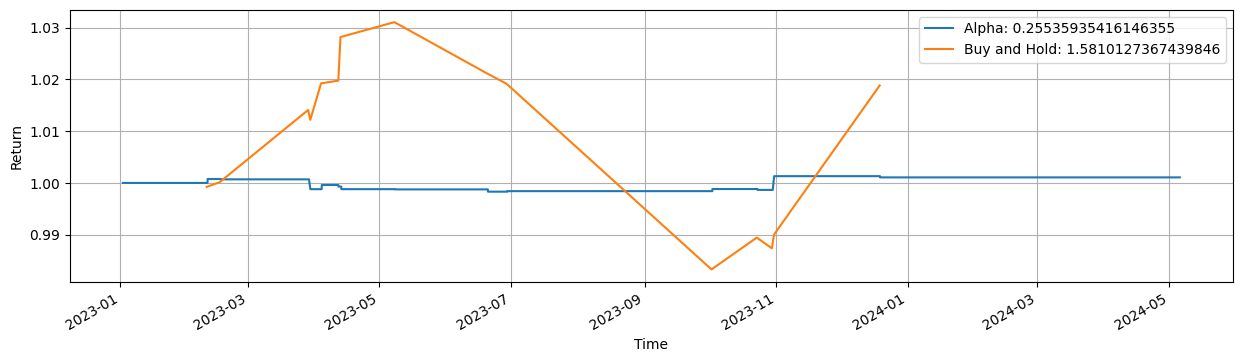

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2023-01-02 04:00:00,0.00000,0.0,0.00000,0.0,1.06972,NaN
2023-01-02 04:15:00,0.00000,0.0,0.00000,0.0,1.06938,1.000000
2023-01-02 04:30:00,0.00000,0.0,0.00000,0.0,1.06951,1.000000
2023-01-02 04:45:00,0.00000,0.0,0.00000,0.0,1.06967,1.000000
2023-01-02 05:00:00,0.00000,0.0,0.00000,0.0,1.06952,1.000000
...,...,...,...,...,...,...
2024-05-06 01:45:00,0.00107,0.0,0.00107,0.0,1.07690,1.001071
2024-05-06 02:00:00,0.00107,0.0,0.00107,0.0,1.07677,1.001071
2024-05-06 02:15:00,0.00107,0.0,0.00107,0.0,1.07687,1.001071


In [14]:
test2_pred_best_gb = best_gb_model.predict(test2[features])
acc_best_gb = accuracy_score(test2[target], test2_pred_best_gb)
f1_best_gb = f1_score(test2[target], test2_pred_best_gb, average='macro')
# precision_best_gb, recall_best_gb, _ = precision_recall_curve(test2[target], test2_pred_best_gb)

print("Best Decision Tree:")
print("Accuracy:", acc_best_gb)
print("F1-score:", f1_best_gb)

backTestInfo = Fx.BacktestInformation(test2['Datetime'], test2_pred_best_gb,test2['Close'],fee=0)
backTestInfo.Plot_PNL()

# Lưu model

In [16]:

# joblib.dump(best_nb_model, '/content/drive/MyDrive/hello_tlu/best_nb_model.pkl')
# joblib.dump(best_dt_model, '/content/drive/MyDrive/hello_tlu/best_dt_model.pkl')
joblib.dump(best_rf_model, '/content/drive/MyDrive/hello_tlu/best_rf_model.pkl')
joblib.dump(best_gb_model, '/content/drive/MyDrive/hello_tlu/best_gb_model.pkl')



['/content/drive/MyDrive/hello_tlu/best_gb_model.pkl']